In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# **Install whisper and ffmpeg for transcribing the audio files**

In [ ]:
# !pip install git+https://github.com/openai/whisper.git
# !sudo apt update && sudo apt install -y ffmpeg

# **Run the whisper model using GPU and store the transcripts into a new csv file**
new csv file is 
>/kaggle/working/whisper_transcribed.csv

In [ ]:
# import os
# import pandas as pd
# import whisper
# import torch
# from tqdm import tqdm

# # Check if CUDA (GPU) is available
# device = "cuda" if torch.cuda.is_available() else "cpu"
# print(f"Using device: {device}")

# # If CUDA is available, print GPU details
# if device == "cuda":
#     print(f"GPU: {torch.cuda.get_device_name()}")
#     print(f"Total GPU Memory: {torch.cuda.get_device_properties(0).total_memory // (1024**2)} MB")
# else:
#     print("No GPU found, using CPU.")

# # Load Whisper's large model and send it to the GPU (or CPU)
# model = whisper.load_model("large").to(device)

# # Load CSV file
# csv_path = "/kaggle/input/shl-intern-hiring-assessment/Dataset/train.csv"
# df = pd.read_csv(csv_path)

# # Audio folder path
# audio_dir = "/kaggle/input/shl-intern-hiring-assessment/Dataset/audios/train"

# # Collect results
# results = []

# # Loop through each audio file
# for idx, row in tqdm(df.iterrows(), total=len(df)):
#     filename = row['filename']
#     label = row['label']
#     audio_path = os.path.join(audio_dir, filename)

#     try:
#         # Transcribe the audio using Whisper model
#         result = model.transcribe(audio_path, fp16=(device == "cuda"))
#         transcription = result['text'].strip()  # Clean up the transcription
#     except Exception as e:
#         print(f"Error transcribing {filename}: {e}")
#         transcription = ""  # If error occurs, leave transcription empty

#     # Append result to the list
#     results.append({
#         'filename': filename,
#         'transcription': transcription,
#         'label': label
#     })

# # Save transcriptions and labels to a new CSV file
# output_df = pd.DataFrame(results)
# output_df.to_csv("whisper_transcribed.csv", index=False)

# print("Transcription completed. The file 'whisper_transcribed.csv' has been saved.")


# **Cleaning the data**
Instead of manually cleaning the data I tried using llama 3.3 via groq api to prompt it and classify the noisy samples however this didn't work out as the model misclassified many samples so I reverted back to manually classifying by myself since the number of records were only 444. Afterwhich I uploaded the new csv file into 
> /kaggle/input/noise-less-data/noise_less - whisper_transcribed.csv

In [3]:
new_samples_df.to_csv("noisy_samples.csv", index=False)

# **Saving the noisy samples to a different csv file.**

In [2]:
import pandas as pd

def find_new_samples(csv1_path, csv2_path):
    """
    Compares two CSV files based on the 'filename' column, identifies samples
    present in the second CSV but not in the first, after removing null values
    from the first CSV.

    Args:
        csv1_path (str): Path to the first CSV file.
        csv2_path (str): Path to the second CSV file.

    Returns:
        pandas.DataFrame: A DataFrame containing the samples from the second CSV
                          that are not present in the first CSV, or an empty DataFrame
                          if an error occurs or no new samples are found.  Returns None if files do not exist.
    """
    try:
        # Load the CSV files into pandas DataFrames.
        df1 = pd.read_csv(csv1_path)
        df2 = pd.read_csv(csv2_path)
    except FileNotFoundError as e:
        print(f"Error: One or both of the CSV files not found: {e}")
        return None  # Explicitly return None for file not found

    # Remove null values from the 'filename' column of the first DataFrame.
    df1 = df1.dropna(subset=['filename'])

    # Get the set of filenames from each DataFrame.
    filenames1 = set(df1['filename'])
    filenames2 = set(df2['filename'])

    # Find the filenames that are in df2 but not in df1.
    new_filenames = filenames2 - filenames1

    # Filter df2 to get only the rows with the new filenames.
    new_samples_df = df2[df2['filename'].isin(new_filenames)]

    return new_samples_df




# Specify the paths to your CSV files.  Replace these with your actual file paths.
csv1_path = "/kaggle/input/noise-less-data/noise_less - whisper_transcribed.csv"  # Replace with your path
csv2_path = "/kaggle/working/whisper_transcribed.csv"  # Replace with your path

# Call the function to find the new samples.
new_samples_df = find_new_samples(csv1_path, csv2_path)

if new_samples_df is None:
    print("Error occurred, cannot proceed") # error message already printed by find_new_samples


# Print the results.
if len(new_samples_df) > 0:
    print("Samples in the second CSV but not in the first CSV:")
    print(new_samples_df.to_string())  # Use to_string() for a nice formatted output, handles many rows
else:
    print("No new samples found.")



Samples in the second CSV but not in the first CSV:
           filename                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

# **Clean the noisy files by changing playback speed and pitch**
I found out that the noisy audio files can be de-noised by increasing the pitch and playback speed so the below code does that.

In [34]:
import os
import pandas as pd
from pydub import AudioSegment
from pydub.effects import speedup
import subprocess

def speed_and_pitch_shift(input_file, output_file, speed_factor=3.0, pitch_shift_cents=1200):
    """
    Speeds up an audio file and increases its pitch using pydub and ffmpeg (rubberband).

    Args:
        input_file (str): Path to the input audio file.
        output_file (str): Path to the output audio file.
        speed_factor (float, optional): The speed factor (e.g., 2.0 for 2x speed). Defaults to 3.0.
        pitch_shift_cents (int, optional): The pitch shift in cents. Defaults to 1200.
    """
    try:
        # 1. Load the audio file using pydub
        audio = AudioSegment.from_file(input_file)

        # 2. Speed up the audio using pydub's speedup function
        sped_up_audio = speedup(audio, playback_speed=speed_factor)

        # 3. Apply pitch shift using ffmpeg and rubberband
        temp_file = "temp_audio.wav"
        sped_up_audio.export(temp_file, format="wav")

        # Convert pitch shift in cents to a ratio for rubberband
        pitch_shift_factor = 2**(pitch_shift_cents / 1200)

        ffmpeg_command = [
            "ffmpeg",
            "-i", temp_file,
            "-filter:a", f"rubberband=pitch={pitch_shift_factor}",
            output_file,
            "-y"
        ]

        result = subprocess.run(ffmpeg_command, capture_output=True, text=True)
        if result.returncode != 0:
            print(f"FFmpeg error: {result.stderr}")
            os.remove(temp_file)
            return

        os.remove(temp_file)
        print(f"Processed: {input_file} -> {output_file}")

    except Exception as e:
        print(f"Error processing {input_file}: {e}")

def process_audio_files_from_csv(csv_file, input_folder, output_folder, speed_factor=3.0, pitch_shift_cents=1200):
    """
    Processes audio files listed in a CSV, applying speed and pitch shift.

    Args:
        csv_file (str): Path to the CSV file containing the filenames.
        input_folder (str): Path to the folder containing the input audio files.
        output_folder (str): Path to the folder where the processed audio files will be saved.
        speed_factor (float, optional): The speed factor. Defaults to 3.0.
        pitch_shift_cents (int, optional): The pitch shift in cents. Defaults to 1200.
    """
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    try:
        df = pd.read_csv(csv_file)
        if 'filename' not in df.columns:
            print(f"Error: 'filename' column not found in {csv_file}")
            return

        for filename in df['filename']:
            input_path = os.path.join(input_folder, filename)
            if os.path.exists(input_path):
                name, ext = os.path.splitext(filename)
                output_filename = f"{name}{ext}"
                output_path = os.path.join(output_folder, output_filename)
                speed_and_pitch_shift(input_path, output_path, speed_factor, pitch_shift_cents)
            else:
                print(f"Warning: Audio file not found: {input_path}")

        print("Processing from CSV done!")

    except FileNotFoundError:
        print(f"Error: CSV file not found at {csv_file}")
    except Exception as e:
        print(f"An error occurred: {e}")


csv_file = "/kaggle/working/noisy_samples.csv"
input_folder = "/kaggle/input/shl-intern-hiring-assessment/Dataset/audios/train"
output_folder = "processed_audio"  # You can change this output folder name
speed_factor = 1.5
pitch_shift_cents = 150  # Shift down by half an octave

# Create the output folder if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
    print(f"Created output folder: {output_folder}")

process_audio_files_from_csv(csv_file, input_folder, output_folder, speed_factor, pitch_shift_cents)
print("All tasks completed!")


Created output folder: processed_audio
Processed: /kaggle/input/shl-intern-hiring-assessment/Dataset/audios/train/audio_710.wav -> processed_audio/audio_710.wav
Processed: /kaggle/input/shl-intern-hiring-assessment/Dataset/audios/train/audio_1265.wav -> processed_audio/audio_1265.wav
Processed: /kaggle/input/shl-intern-hiring-assessment/Dataset/audios/train/audio_150.wav -> processed_audio/audio_150.wav
Processed: /kaggle/input/shl-intern-hiring-assessment/Dataset/audios/train/audio_921.wav -> processed_audio/audio_921.wav
Processed: /kaggle/input/shl-intern-hiring-assessment/Dataset/audios/train/audio_1116.wav -> processed_audio/audio_1116.wav
Processed: /kaggle/input/shl-intern-hiring-assessment/Dataset/audios/train/audio_908.wav -> processed_audio/audio_908.wav
Processed: /kaggle/input/shl-intern-hiring-assessment/Dataset/audios/train/audio_151.wav -> processed_audio/audio_151.wav
Processed: /kaggle/input/shl-intern-hiring-assessment/Dataset/audios/train/audio_387.wav -> processed_a

# **Couldn't clean the noisy data.**
**I tried cleaning the noisy data by adjusting the pitch and the playback speed but majority of the data doesn't get cleaned as each audio requires seperate amount of pitch and playback speed tuning which would be very hard to do manually so I decided to drop the noisy data.**

# **Removed null values and saving it into a new csv file**
Removed the null values from the csv file and saved it into a new csv file.
>/kaggle/working/noise-less_nan_removed.csv

In [3]:
import pandas as pd

# Path to your original CSV file
csv_file_path = '/kaggle/input/noise-less-data/noise_less - whisper_transcribed.csv'

# Path to save the new CSV file
new_csv_file_path = '/kaggle/working/noise-less_nan_removed.csv'

try:
    # Load the DataFrame
    df = pd.read_csv(csv_file_path)

    print("Original DataFrame:")
    print(df.head())
    print(f"\nNumber of null values before removal:\n{df.isnull().sum()}")

    # Remove rows with null values and update the DataFrame in place
    df.dropna(inplace=True)

    print("\nDataFrame after removing rows with nulls:")
    print(df.head())
    print(f"\nNumber of null values after removal:\n{df.isnull().sum()}")

    # Save the modified DataFrame to a new CSV file
    df.to_csv(new_csv_file_path, index=False)  # index=False prevents writing the DataFrame index to the CSV

    print(f"\nCleaned data saved to: {new_csv_file_path}")

except FileNotFoundError:
    print(f"Error: File not found at {csv_file_path}")
except Exception as e:
    print(f"An error occurred: {e}")


Original DataFrame:
         filename                                      transcription  label
0             NaN                                                NaN    NaN
1             NaN                                                NaN    NaN
2  audio_1114.wav  My goal is to become an electrical employee an...    1.5
3   audio_946.wav  The playground looks like very clear and neat ...    1.5
4  audio_1127.wav  My goal is to bring my parents to live with me...    2.0

Number of null values before removal:
filename         80
transcription    80
label            80
dtype: int64

DataFrame after removing rows with nulls:
         filename                                      transcription  label
2  audio_1114.wav  My goal is to become an electrical employee an...    1.5
3   audio_946.wav  The playground looks like very clear and neat ...    1.5
4  audio_1127.wav  My goal is to bring my parents to live with me...    2.0
5   audio_669.wav  Today I am going to speak about the topic name

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


# **Run the model - LSTM and CNN with regression head**
Ran both LSTM and CNN for 20 epochs.

In [6]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from transformers import BertTokenizer, BertModel
from tqdm import tqdm
import math
from torch.utils.tensorboard import SummaryWriter
import os
from datetime import datetime

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check for GPU availability and set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Create a directory for TensorBoard logs
log_dir = os.path.join("runs", datetime.now().strftime("%Y%m%d-%H%M%S"))
os.makedirs(log_dir, exist_ok=True)

# Initialize TensorBoard writers for each model
lstm_writer = SummaryWriter(os.path.join(log_dir, "LSTM"))
cnn_writer = SummaryWriter(os.path.join(log_dir, "CNN"))

# Load the data
# Replace with your actual file path
df = pd.read_csv('/kaggle/working/noise-less_nan_removed.csv')

# Keep only the necessary columns
df = df[['transcription', 'label']]

print(f"Dataset shape: {df.shape}")
print(df.head())

# Check for any missing values
print(f"Missing values:\n{df.isnull().sum()}")

# Create a PyTorch dataset
class GrammarDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = float(self.labels[idx])
        
        # Tokenize the text
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.float)
        }

# Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Split the data into training and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['transcription'].values, 
    df['label'].values,
    test_size=0.2,
    random_state=42
)

# Create datasets
train_dataset = GrammarDataset(train_texts, train_labels, tokenizer)
val_dataset = GrammarDataset(val_texts, val_labels, tokenizer)

# Create data loaders with pin_memory for faster GPU data transfer
batch_size = 16  # Increased batch size for GPU utilization
train_loader = DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    shuffle=True,
    pin_memory=True,  # Pin memory for faster data transfer to GPU
    num_workers=4     # Parallel data loading
)
val_loader = DataLoader(
    val_dataset, 
    batch_size=batch_size,
    pin_memory=True,
    num_workers=4
)

# -------------------- Model 1: BERT + LSTM with Regression Head --------------------
class BertLSTMGrammarScorer(nn.Module):
    def __init__(self, bert_model='bert-base-uncased', lstm_hidden_size=256, dropout_rate=0.3):
        super(BertLSTMGrammarScorer, self).__init__()
        self.bert = BertModel.from_pretrained(bert_model)
        self.lstm = nn.LSTM(
            input_size=self.bert.config.hidden_size,
            hidden_size=lstm_hidden_size,
            num_layers=3,
            batch_first=True,
            bidirectional=True,
            dropout=dropout_rate if lstm_hidden_size > 1 else 0
        )
        self.dropout = nn.Dropout(dropout_rate)
        
        # Regression head
        self.regressor = nn.Sequential(
            nn.Linear(lstm_hidden_size * 2, 128),  # * 2 because bidirectional
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(128, 1)
        )
        
    def forward(self, input_ids, attention_mask):
        # Get BERT embeddings
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        sequence_output = outputs.last_hidden_state  # [batch_size, seq_len, hidden_size]
        
        # Pass through LSTM
        lstm_output, (hidden, _) = self.lstm(sequence_output)
        
        # Get the final hidden state from both directions
        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)  # [batch_size, hidden_size*2]
        
        # Apply dropout
        hidden = self.dropout(hidden)
        
        # Regression head
        score = self.regressor(hidden)
        
        return score

# -------------------- Model 2: BERT + CNN with Regression Head --------------------
class BertCNNGrammarScorer(nn.Module):
    def __init__(self, bert_model='bert-base-uncased', dropout_rate=0.3):
        super(BertCNNGrammarScorer, self).__init__()
        self.bert = BertModel.from_pretrained(bert_model)
        
        # CNN layers with different kernel sizes for capturing different n-gram features
        self.conv1 = nn.Conv1d(in_channels=self.bert.config.hidden_size, out_channels=128, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=self.bert.config.hidden_size, out_channels=128, kernel_size=4, padding=1)
        self.conv3 = nn.Conv1d(in_channels=self.bert.config.hidden_size, out_channels=128, kernel_size=5, padding=2)
        
        self.dropout = nn.Dropout(dropout_rate)
        self.relu = nn.ReLU()
        
        # Regression head
        self.regressor = nn.Sequential(
            nn.Linear(128*3, 128),  # Concatenated output from 3 conv layers
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(128, 1)
        )
        
    def forward(self, input_ids, attention_mask):
        # Get BERT embeddings
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        sequence_output = outputs.last_hidden_state  # [batch_size, seq_len, hidden_size]
        
        # Transpose for CNN (expecting [batch, channels, seq_len])
        x = sequence_output.transpose(1, 2)  # [batch_size, hidden_size, seq_len]
        
        # Apply CNN layers
        c1 = self.relu(self.conv1(x))  # [batch_size, 128, seq_len]
        c2 = self.relu(self.conv2(x))  # [batch_size, 128, seq_len]
        c3 = self.relu(self.conv3(x))  # [batch_size, 128, seq_len]
        
        # Global max pooling
        c1 = torch.max(c1, dim=2)[0]  # [batch_size, 128]
        c2 = torch.max(c2, dim=2)[0]  # [batch_size, 128]
        c3 = torch.max(c3, dim=2)[0]  # [batch_size, 128]
        
        # Concatenate
        cnn_output = torch.cat((c1, c2, c3), dim=1)  # [batch_size, 384]
        
        # Apply dropout
        cnn_output = self.dropout(cnn_output)
        
        # Regression head
        score = self.regressor(cnn_output)
        
        return score

# Add dummy input for visualizing model graph in TensorBoard
def add_model_graph_to_tensorboard(model, writer):
    dummy_input_ids = torch.zeros((1, 512), dtype=torch.long).to(device)
    dummy_attention_mask = torch.ones((1, 512), dtype=torch.long).to(device)
    writer.add_graph(model, [dummy_input_ids, dummy_attention_mask])

# Improved training function with mixed precision and TensorBoard logging for faster GPU training
def train_model(model, train_loader, val_loader, optimizer, criterion, writer, num_epochs=5, use_amp=True, model_name="model"):
    best_val_loss = float('inf')
    history = {
        'train_loss': [],
        'val_loss': [],
        'val_mse': [],
        'val_mae': [],
        'val_rmse': [],
        'val_r2': []
    }
    
    # Initialize scaler for mixed precision training
    scaler = torch.cuda.amp.GradScaler() if use_amp else None
    
    # Log model graph to TensorBoard
    try:
        add_model_graph_to_tensorboard(model, writer)
    except Exception as e:
        print(f"Error adding model graph to TensorBoard: {e}")
    
    # Log hyperparameters
    writer.add_hparams(
        {
            'model_type': model_name,
            'batch_size': batch_size,
            'learning_rate': optimizer.param_groups[0]['lr'],
            'weight_decay': optimizer.param_groups[0]['weight_decay'],
            'use_amp': use_amp
        },
        {}  # Metrics will be added during training
    )
    
    global_step = 0
    
    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0
        train_steps = 0
        
        # Create progress bar for training
        train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]")
        
        for batch in train_pbar:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            
            # Clear gradients
            optimizer.zero_grad()
            
            if use_amp and torch.cuda.is_available():
                # Use mixed precision for faster training
                with torch.cuda.amp.autocast():
                    outputs = model(input_ids, attention_mask)
                    loss = criterion(outputs.view(-1), labels)
                
                # Scale gradients and optimize
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                # Standard training
                outputs = model(input_ids, attention_mask)
                loss = criterion(outputs.view(-1), labels)
                loss.backward()
                optimizer.step()
            
            # Log training loss
            train_loss += loss.item()
            train_steps += 1
            batch_loss = loss.item()
            
            # Update progress bar with current loss
            train_pbar.set_postfix({'loss': f"{batch_loss:.4f}"})
            
            # Log batch loss to TensorBoard
            writer.add_scalar('Loss/train_batch', batch_loss, global_step)
            global_step += 1
        
        avg_train_loss = train_loss / train_steps
        history['train_loss'].append(avg_train_loss)
        
        # Log average training loss for the epoch
        writer.add_scalar('Loss/train_epoch', avg_train_loss, epoch)
        
        # Validation
        model.eval()
        val_loss = 0
        val_steps = 0
        all_preds = []
        all_labels = []
        
        # Create progress bar for validation
        val_pbar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]")
        
        with torch.no_grad():
            for batch in val_pbar:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['label'].to(device)
                
                # No need for mixed precision in validation
                outputs = model(input_ids, attention_mask)
                loss = criterion(outputs.view(-1), labels)
                
                val_loss += loss.item()
                val_steps += 1
                
                # Update validation progress bar
                val_pbar.set_postfix({'loss': f"{loss.item():.4f}"})
                
                all_preds.extend(outputs.view(-1).cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        
        # Calculate metrics
        avg_val_loss = val_loss / val_steps
        val_mse = mean_squared_error(all_labels, all_preds)
        val_mae = mean_absolute_error(all_labels, all_preds)
        val_rmse = math.sqrt(val_mse)
        val_r2 = r2_score(all_labels, all_preds)
        
        # Store metrics
        history['val_loss'].append(avg_val_loss)
        history['val_mse'].append(val_mse)
        history['val_mae'].append(val_mae)
        history['val_rmse'].append(val_rmse)
        history['val_r2'].append(val_r2)
        
        # Log validation metrics to TensorBoard
        writer.add_scalar('Loss/validation', avg_val_loss, epoch)
        writer.add_scalar('Metrics/MSE', val_mse, epoch)
        writer.add_scalar('Metrics/RMSE', val_rmse, epoch)
        writer.add_scalar('Metrics/MAE', val_mae, epoch)
        writer.add_scalar('Metrics/R2', val_r2, epoch)
        
        # Add learning rate to TensorBoard
        current_lr = optimizer.param_groups[0]['lr']
        writer.add_scalar('Learning_rate', current_lr, epoch)
        
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {avg_train_loss:.4f}")
        print(f"Val Loss: {avg_val_loss:.4f}, MSE: {val_mse:.4f}, RMSE: {val_rmse:.4f}, MAE: {val_mae:.4f}, R²: {val_r2:.4f}")
        
        # Update learning rate scheduler if provided
        if hasattr(optimizer, 'scheduler'):
            optimizer.scheduler.step(avg_val_loss)
        
        # Save the best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            model_save_path = f"{model_name}_best.pt"
            torch.save(model.state_dict(), model_save_path)
            print(f"Best model saved to {model_save_path}!")
            
            # Log best metrics as hyperparameter metrics
            writer.add_hparams(
                {},  # Empty since we already logged hyperparameters
                {
                    'hparam/best_val_loss': best_val_loss,
                    'hparam/best_val_mse': val_mse,
                    'hparam/best_val_rmse': val_rmse,
                    'hparam/best_val_mae': val_mae,
                    'hparam/best_val_r2': val_r2
                }
            )
        
        # Add distributions of network weights to TensorBoard
        for name, param in model.named_parameters():
            if 'weight' in name:
                writer.add_histogram(f'Weights/{name}', param.data, epoch)
                if param.grad is not None:
                    writer.add_histogram(f'Gradients/{name}', param.grad, epoch)
        
        # Enable grad tracking again
        torch.set_grad_enabled(True)
    
    # Create a distribution chart of errors
    predictions, actual = predict(model, val_loader)
    errors = actual - predictions
    
    writer.add_histogram('Error_Distribution', np.array(errors), epoch)
    
    # Add embedding visualization for select samples (first 100)
    try:
        if epoch == num_epochs - 1:  # Only at the end to save computation
            visualize_embeddings(model, writer, train_loader, limit=100)
    except Exception as e:
        print(f"Error visualizing embeddings: {e}")
    
    # Close the writer after training
    writer.close()
    
    return history

# Function to visualize embeddings in TensorBoard
def visualize_embeddings(model, writer, dataloader, limit=100):
    model.eval()
    embeddings = []
    labels = []
    texts = []
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Extracting embeddings"):
            # Process only a limited number of samples
            if len(embeddings) >= limit:
                break
                
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            batch_labels = batch['label'].cpu().numpy()
            
            # Get BERT embeddings (CLS token)
            outputs = model.bert(input_ids=input_ids, attention_mask=attention_mask)
            cls_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
            
            # Store embeddings and metadata
            for i in range(len(cls_embeddings)):
                if len(embeddings) < limit:
                    embeddings.append(cls_embeddings[i])
                    labels.append(batch_labels[i])
                    
                    # Decode text for metadata
                    text = tokenizer.decode(input_ids[i].cpu().numpy(), skip_special_tokens=True)
                    texts.append(text[:50])  # Truncate text for cleaner visualization
                else:
                    break
    
    # Add embeddings to TensorBoard
    embeddings = np.array(embeddings)
    writer.add_embedding(
        embeddings,
        metadata=[f"Score: {l:.2f}" for l in labels],
        tag="BERT_CLS_Embeddings"
    )

# Improved prediction function with efficient GPU utilization
def predict(model, dataloader):
    model.eval()
    predictions = []
    actual = []
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Predicting"):
            # Move data to GPU in one go
            batch = {k: v.to(device) for k, v in batch.items()}
            
            # Forward pass
            outputs = model(batch['input_ids'], batch['attention_mask'])
            
            # Collect predictions and actual values
            preds = outputs.view(-1).cpu().numpy()
            labels = batch['label'].cpu().numpy()
            
            # Handle single item tensors and batches consistently
            predictions.extend(preds)
            actual.extend(labels)
    
    return np.array(predictions), np.array(actual)

# Updated evaluation function with TensorBoard visualization
def evaluate_model(model_path, model_class, writer, model_type="lstm"):
    # Load the model
    if model_class == BertLSTMGrammarScorer:
        model = BertLSTMGrammarScorer().to(device)
    else:  # CNN
        model = BertCNNGrammarScorer().to(device)
    
    # Load model weights
    if torch.cuda.is_available():
        model.load_state_dict(torch.load(model_path, map_location=device))
    else:
        model.load_state_dict(torch.load(model_path, map_location='cpu'))
    
    # Get predictions on validation set
    predictions, actual = predict(model, val_loader)
    
    # Calculate metrics
    mse = mean_squared_error(actual, predictions)
    rmse = math.sqrt(mse)
    mae = mean_absolute_error(actual, predictions)
    r2 = r2_score(actual, predictions)
    
    print(f"Model: {model_type.upper()}")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R²: {r2:.4f}")
    
    # Log final evaluation metrics to TensorBoard
    writer.add_hparams(
        {'model_type': model_type},
        {
            'hparam/final_mse': mse,
            'hparam/final_rmse': rmse,
            'hparam/final_mae': mae,
            'hparam/final_r2': r2
        }
    )
    
    # Create a scatter plot of actual vs predicted values
    writer.add_figure(
        'Predictions/Actual_vs_Predicted',
        create_scatter_plot(actual, predictions, model_type),
        global_step=0
    )
    
    # Create a dataframe with results for analysis
    results_df = pd.DataFrame({
        'Actual': actual,
        'Predicted': predictions,
        'Error': actual - predictions
    })
    
    return results_df, mse, rmse, mae, r2

# Function to create scatter plot for TensorBoard
def create_scatter_plot(actual, predicted, model_type):
    import matplotlib.pyplot as plt
    
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # Plot actual vs predicted
    ax.scatter(actual, predicted, alpha=0.5)
    
    # Plot the perfect prediction line
    min_val = min(min(actual), min(predicted))
    max_val = max(max(actual), max(predicted))
    ax.plot([min_val, max_val], [min_val, max_val], 'r--')
    
    # Add labels and title
    ax.set_xlabel('Actual Values')
    ax.set_ylabel('Predicted Values')
    ax.set_title(f'{model_type.upper()} Model: Actual vs Predicted Values')
    
    # Add correlation coefficient
    correlation = np.corrcoef(actual, predicted)[0, 1]
    ax.text(0.05, 0.95, f'Correlation: {correlation:.4f}', transform=ax.transAxes)
    
    return fig

# Train the LSTM model with mixed precision
print("Training BERT + LSTM model with GPU optimization and TensorBoard logging...")
lstm_model = BertLSTMGrammarScorer().to(device)

# Apply gradient checkpointing to save memory (especially useful for large models)
lstm_model.bert.gradient_checkpointing_enable()

# Use a learning rate scheduler to improve convergence
optimizer_lstm = optim.AdamW(lstm_model.parameters(), lr=2e-5, weight_decay=0.01)
scheduler_lstm = optim.lr_scheduler.ReduceLROnPlateau(optimizer_lstm, mode='min', factor=0.5, patience=2, verbose=True)
optimizer_lstm.scheduler = scheduler_lstm  # Attach scheduler to optimizer for access in train_model
criterion = nn.MSELoss()

# Train the LSTM model
lstm_history = train_model(
    model=lstm_model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer_lstm,
    criterion=criterion,
    writer=lstm_writer,
    num_epochs=20,  # Adjust based on computational resources
    use_amp=True,   # Use mixed precision
    model_name="LSTM"
)

# Now train the CNN model with mixed precision
print("Training BERT + CNN model with GPU optimization and TensorBoard logging...")
cnn_model = BertCNNGrammarScorer().to(device)

# Apply gradient checkpointing to save memory
cnn_model.bert.gradient_checkpointing_enable()

# Use a learning rate scheduler for the CNN model
optimizer_cnn = optim.AdamW(cnn_model.parameters(), lr=2e-5, weight_decay=0.01)
scheduler_cnn = optim.lr_scheduler.ReduceLROnPlateau(optimizer_cnn, mode='min', factor=0.5, patience=2, verbose=True)
optimizer_cnn.scheduler = scheduler_cnn  # Attach scheduler to optimizer for access in train_model

# Train the CNN model
cnn_history = train_model(
    model=cnn_model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer_cnn,
    criterion=criterion,
    writer=cnn_writer,
    num_epochs=20,  # Adjust based on computational resources
    use_amp=True,   # Use mixed precision
    model_name="CNN"
)

# Evaluate the trained models and log results to TensorBoard
print("Evaluating LSTM model...")
lstm_results, lstm_mse, lstm_rmse, lstm_mae, lstm_r2 = evaluate_model(
    "LSTM_best.pt", 
    BertLSTMGrammarScorer,
    lstm_writer,
    model_type="lstm"
)

print("Evaluating CNN model...")
cnn_results, cnn_mse, cnn_rmse, cnn_mae, cnn_r2 = evaluate_model(
    "CNN_best.pt",
    BertCNNGrammarScorer,
    cnn_writer,
    model_type="cnn"
)

# Add model comparison to both writers for easy access
comparison_data = {
    'Model': ['LSTM', 'CNN'],
    'MSE': [lstm_mse, cnn_mse],
    'RMSE': [lstm_rmse, cnn_rmse],
    'MAE': [lstm_mae, cnn_mae],
    'R²': [lstm_r2, cnn_r2]
}

# Create a comparison bar chart
def create_comparison_chart(comparison_data):
    import matplotlib.pyplot as plt
    
    metrics = ['MSE', 'RMSE', 'MAE']
    lstm_values = [comparison_data['MSE'][0], comparison_data['RMSE'][0], comparison_data['MAE'][0]]
    cnn_values = [comparison_data['MSE'][1], comparison_data['RMSE'][1], comparison_data['MAE'][1]]
    
    fig, ax = plt.subplots(figsize=(10, 6))
    x = np.arange(len(metrics))
    width = 0.35
    
    ax.bar(x - width/2, lstm_values, width, label='LSTM')
    ax.bar(x + width/2, cnn_values, width, label='CNN')
    
    ax.set_xlabel('Metrics')
    ax.set_ylabel('Value')
    ax.set_title('Model Comparison: Error Metrics')
    ax.set_xticks(x)
    ax.set_xticklabels(metrics)
    ax.legend()
    
    # Add R² as text
    ax.text(0.05, 0.95, f"LSTM R²: {comparison_data['R²'][0]:.4f}", transform=ax.transAxes)
    ax.text(0.05, 0.90, f"CNN R²: {comparison_data['R²'][1]:.4f}", transform=ax.transAxes)
    
    return fig

# Add comparison chart to both writers
comparison_chart = create_comparison_chart(comparison_data)
lstm_writer.add_figure('Comparison/Error_Metrics', comparison_chart)
cnn_writer.add_figure('Comparison/Error_Metrics', comparison_chart)

print(f"TensorBoard logs saved to {log_dir}")
print("To view the TensorBoard dashboard, run: tensorboard --logdir=runs")

# Close TensorBoard writers
lstm_writer.close()
cnn_writer.close()

2025-04-20 17:52:35.241104: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745171555.405336      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745171555.451518      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Using device: cuda
Dataset shape: (364, 2)
                                       transcription  label
0  My goal is to become an electrical employee an...    1.5
1  The playground looks like very clear and neat ...    1.5
2  My goal is to bring my parents to live with me...    2.0
3  Today I am going to speak about the topic name...    2.0
4  I would like to go the Saachi for the Saachi s...    2.0
Missing values:
transcription    0
label            0
dtype: int64


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


Training BERT + LSTM model with GPU optimization and TensorBoard logging...


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

/tmp/ipykernel_31/4244783987.py:221: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if use_amp else None
`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.
Epoch 1/20 [Train]:   0%|          | 0/19 [00:00<?, ?it/s]/tmp/ipykernel_31/4244783987.py:262: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1/20 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.63it/s, loss=15.2133]


Epoch 1/20
Train Loss: 16.5981
Val Loss: 14.5995, MSE: 14.5407, RMSE: 3.8132, MAE: 3.6481, R²: -10.7995
Best model saved to LSTM_best.pt!


Epoch 2/20 [Train]:   0%|          | 0/19 [00:00<?, ?it/s]/tmp/ipykernel_31/4244783987.py:262: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 2/20 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.65it/s, loss=13.4701]


Epoch 2/20
Train Loss: 15.2996
Val Loss: 12.9298, MSE: 12.8780, RMSE: 3.5886, MAE: 3.4126, R²: -9.4503
Best model saved to LSTM_best.pt!


Epoch 3/20 [Train]:   0%|          | 0/19 [00:00<?, ?it/s]/tmp/ipykernel_31/4244783987.py:262: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 3/20 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.61it/s, loss=10.4208]


Epoch 3/20
Train Loss: 13.2385
Val Loss: 10.0238, MSE: 9.9857, RMSE: 3.1600, MAE: 2.9586, R²: -7.1033
Best model saved to LSTM_best.pt!


Epoch 4/20 [Train]:   0%|          | 0/19 [00:00<?, ?it/s]/tmp/ipykernel_31/4244783987.py:262: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 4/20 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.54it/s, loss=6.0492]


Epoch 4/20
Train Loss: 9.3193
Val Loss: 5.9059, MSE: 5.8921, RMSE: 2.4274, MAE: 2.1601, R²: -3.7814
Best model saved to LSTM_best.pt!


Epoch 5/20 [Train]:   0%|          | 0/19 [00:00<?, ?it/s]/tmp/ipykernel_31/4244783987.py:262: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 5/20 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.54it/s, loss=2.3776]


Epoch 5/20
Train Loss: 5.0470
Val Loss: 2.5550, MSE: 2.5721, RMSE: 1.6038, MAE: 1.3611, R²: -1.0872
Best model saved to LSTM_best.pt!


Epoch 6/20 [Train]:   0%|          | 0/19 [00:00<?, ?it/s]/tmp/ipykernel_31/4244783987.py:262: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 6/20 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.60it/s, loss=0.8676]


Epoch 6/20
Train Loss: 2.1918
Val Loss: 1.3071, MSE: 1.3492, RMSE: 1.1616, MAE: 1.0371, R²: -0.0949
Best model saved to LSTM_best.pt!


Epoch 7/20 [Train]:   0%|          | 0/19 [00:00<?, ?it/s]/tmp/ipykernel_31/4244783987.py:262: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 7/20 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.62it/s, loss=0.6001]


Epoch 7/20
Train Loss: 1.3469
Val Loss: 1.1950, MSE: 1.2520, RMSE: 1.1189, MAE: 0.9729, R²: -0.0160
Best model saved to LSTM_best.pt!


Epoch 8/20 [Train]:   0%|          | 0/19 [00:00<?, ?it/s]/tmp/ipykernel_31/4244783987.py:262: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 8/20 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.59it/s, loss=0.6165]


Epoch 8/20
Train Loss: 1.2118
Val Loss: 1.2656, MSE: 1.3279, RMSE: 1.1523, MAE: 0.9634, R²: -0.0775


Epoch 9/20 [Train]:   0%|          | 0/19 [00:00<?, ?it/s]/tmp/ipykernel_31/4244783987.py:262: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 9/20 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.61it/s, loss=0.6100]


Epoch 9/20
Train Loss: 1.2687
Val Loss: 1.2511, MSE: 1.3126, RMSE: 1.1457, MAE: 0.9592, R²: -0.0651


Epoch 10/20 [Train]:   0%|          | 0/19 [00:00<?, ?it/s]/tmp/ipykernel_31/4244783987.py:262: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 10/20 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.65it/s, loss=0.6107]


Epoch 10/20
Train Loss: 1.3550
Val Loss: 1.2523, MSE: 1.3139, RMSE: 1.1462, MAE: 0.9587, R²: -0.0662


Epoch 11/20 [Train]:   0%|          | 0/19 [00:00<?, ?it/s]/tmp/ipykernel_31/4244783987.py:262: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 11/20 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.62it/s, loss=0.5991]


Epoch 11/20
Train Loss: 1.2577
Val Loss: 1.2191, MSE: 1.2786, RMSE: 1.1307, MAE: 0.9634, R²: -0.0375


Epoch 12/20 [Train]:   0%|          | 0/19 [00:00<?, ?it/s]/tmp/ipykernel_31/4244783987.py:262: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 12/20 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.64it/s, loss=0.5969]


Epoch 12/20
Train Loss: 1.2379
Val Loss: 1.2073, MSE: 1.2659, RMSE: 1.1251, MAE: 0.9588, R²: -0.0272


Epoch 13/20 [Train]:   0%|          | 0/19 [00:00<?, ?it/s]/tmp/ipykernel_31/4244783987.py:262: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 13/20 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.63it/s, loss=0.5751]


Epoch 13/20
Train Loss: 1.2269
Val Loss: 1.1317, MSE: 1.1851, RMSE: 1.0886, MAE: 0.9323, R²: 0.0383
Best model saved to LSTM_best.pt!


Epoch 14/20 [Train]:   0%|          | 0/19 [00:00<?, ?it/s]/tmp/ipykernel_31/4244783987.py:262: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 14/20 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.61it/s, loss=0.6204]


Epoch 14/20
Train Loss: 1.2024
Val Loss: 1.2727, MSE: 1.3353, RMSE: 1.1555, MAE: 0.9666, R²: -0.0835


Epoch 15/20 [Train]:   0%|          | 0/19 [00:00<?, ?it/s]/tmp/ipykernel_31/4244783987.py:262: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 15/20 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.59it/s, loss=0.6248]


Epoch 15/20
Train Loss: 1.3183
Val Loss: 1.2830, MSE: 1.3461, RMSE: 1.1602, MAE: 0.9697, R²: -0.0924


Epoch 16/20 [Train]:   0%|          | 0/19 [00:00<?, ?it/s]/tmp/ipykernel_31/4244783987.py:262: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 16/20 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.61it/s, loss=0.6023]


Epoch 16/20
Train Loss: 1.2008
Val Loss: 1.2264, MSE: 1.2863, RMSE: 1.1341, MAE: 0.9589, R²: -0.0438


Epoch 17/20 [Train]:   0%|          | 0/19 [00:00<?, ?it/s]/tmp/ipykernel_31/4244783987.py:262: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 17/20 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.60it/s, loss=0.5955]


Epoch 17/20
Train Loss: 1.2157
Val Loss: 1.1968, MSE: 1.2544, RMSE: 1.1200, MAE: 0.9554, R²: -0.0179


Epoch 18/20 [Train]:   0%|          | 0/19 [00:00<?, ?it/s]/tmp/ipykernel_31/4244783987.py:262: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 18/20 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.60it/s, loss=0.5891]


Epoch 18/20
Train Loss: 1.2269
Val Loss: 1.1425, MSE: 1.1956, RMSE: 1.0934, MAE: 0.9389, R²: 0.0298


Epoch 19/20 [Train]:   0%|          | 0/19 [00:00<?, ?it/s]/tmp/ipykernel_31/4244783987.py:262: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 19/20 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.59it/s, loss=0.5398]


Epoch 19/20
Train Loss: 1.2065
Val Loss: 0.9395, MSE: 0.9778, RMSE: 0.9888, MAE: 0.8709, R²: 0.2066
Best model saved to LSTM_best.pt!


Epoch 20/20 [Train]:   0%|          | 0/19 [00:00<?, ?it/s]/tmp/ipykernel_31/4244783987.py:262: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 20/20 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.59it/s, loss=0.4001]


Epoch 20/20
Train Loss: 0.9842
Val Loss: 0.5395, MSE: 0.5529, RMSE: 0.7436, MAE: 0.6070, R²: 0.5513
Best model saved to LSTM_best.pt!


Extracting embeddings:  37%|███▋      | 7/19 [00:02<00:04,  2.62it/s]


Training BERT + CNN model with GPU optimization and TensorBoard logging...


/tmp/ipykernel_31/4244783987.py:221: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if use_amp else None
Epoch 1/20 [Train]:   0%|          | 0/19 [00:00<?, ?it/s]/tmp/ipykernel_31/4244783987.py:262: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1/20 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.96it/s, loss=6.7780]


Epoch 1/20
Train Loss: 13.3284
Val Loss: 6.5929, MSE: 6.5751, RMSE: 2.5642, MAE: 2.3256, R²: -4.3356
Best model saved to CNN_best.pt!


Epoch 2/20 [Train]:   0%|          | 0/19 [00:00<?, ?it/s]/tmp/ipykernel_31/4244783987.py:262: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 2/20 [Val]: 100%|██████████| 5/5 [00:01<00:00,  3.01it/s, loss=1.3118]


Epoch 2/20
Train Loss: 4.3577
Val Loss: 1.6615, MSE: 1.6950, RMSE: 1.3019, MAE: 1.1123, R²: -0.3755
Best model saved to CNN_best.pt!


Epoch 3/20 [Train]:   0%|          | 0/19 [00:00<?, ?it/s]/tmp/ipykernel_31/4244783987.py:262: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 3/20 [Val]: 100%|██████████| 5/5 [00:01<00:00,  3.03it/s, loss=0.5274]


Epoch 3/20
Train Loss: 1.6923
Val Loss: 1.0832, MSE: 1.1365, RMSE: 1.0661, MAE: 0.9090, R²: 0.0778
Best model saved to CNN_best.pt!


Epoch 4/20 [Train]:   0%|          | 0/19 [00:00<?, ?it/s]/tmp/ipykernel_31/4244783987.py:262: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 4/20 [Val]: 100%|██████████| 5/5 [00:01<00:00,  3.04it/s, loss=0.3412]


Epoch 4/20
Train Loss: 1.3515
Val Loss: 0.8680, MSE: 0.9185, RMSE: 0.9584, MAE: 0.8037, R²: 0.2546
Best model saved to CNN_best.pt!


Epoch 5/20 [Train]:   0%|          | 0/19 [00:00<?, ?it/s]/tmp/ipykernel_31/4244783987.py:262: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 5/20 [Val]: 100%|██████████| 5/5 [00:01<00:00,  3.00it/s, loss=0.2750]


Epoch 5/20
Train Loss: 1.0905
Val Loss: 0.6336, MSE: 0.6680, RMSE: 0.8173, MAE: 0.6743, R²: 0.4580
Best model saved to CNN_best.pt!


Epoch 6/20 [Train]:   0%|          | 0/19 [00:00<?, ?it/s]/tmp/ipykernel_31/4244783987.py:262: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 6/20 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.99it/s, loss=0.8792]


Epoch 6/20
Train Loss: 0.8542
Val Loss: 0.7161, MSE: 0.7005, RMSE: 0.8370, MAE: 0.6893, R²: 0.4316


Epoch 7/20 [Train]:   0%|          | 0/19 [00:00<?, ?it/s]/tmp/ipykernel_31/4244783987.py:262: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 7/20 [Val]: 100%|██████████| 5/5 [00:01<00:00,  3.03it/s, loss=0.1967]


Epoch 7/20
Train Loss: 0.7758
Val Loss: 0.5324, MSE: 0.5646, RMSE: 0.7514, MAE: 0.5939, R²: 0.5419
Best model saved to CNN_best.pt!


Epoch 8/20 [Train]:   0%|          | 0/19 [00:00<?, ?it/s]/tmp/ipykernel_31/4244783987.py:262: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 8/20 [Val]: 100%|██████████| 5/5 [00:01<00:00,  3.02it/s, loss=0.3916]


Epoch 8/20
Train Loss: 0.5693
Val Loss: 0.7142, MSE: 0.7451, RMSE: 0.8632, MAE: 0.6679, R²: 0.3954


Epoch 9/20 [Train]:   0%|          | 0/19 [00:00<?, ?it/s]/tmp/ipykernel_31/4244783987.py:262: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 9/20 [Val]: 100%|██████████| 5/5 [00:01<00:00,  3.00it/s, loss=0.3498]


Epoch 9/20
Train Loss: 0.6522
Val Loss: 0.4096, MSE: 0.4153, RMSE: 0.6444, MAE: 0.5344, R²: 0.6630
Best model saved to CNN_best.pt!


Epoch 10/20 [Train]:   0%|          | 0/19 [00:00<?, ?it/s]/tmp/ipykernel_31/4244783987.py:262: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 10/20 [Val]: 100%|██████████| 5/5 [00:01<00:00,  3.00it/s, loss=0.2384]


Epoch 10/20
Train Loss: 0.5802
Val Loss: 0.3543, MSE: 0.3655, RMSE: 0.6045, MAE: 0.4782, R²: 0.7034
Best model saved to CNN_best.pt!


Epoch 11/20 [Train]:   0%|          | 0/19 [00:00<?, ?it/s]/tmp/ipykernel_31/4244783987.py:262: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 11/20 [Val]: 100%|██████████| 5/5 [00:01<00:00,  3.05it/s, loss=0.2534]


Epoch 11/20
Train Loss: 0.4834
Val Loss: 0.4332, MSE: 0.4504, RMSE: 0.6711, MAE: 0.5226, R²: 0.6345


Epoch 12/20 [Train]:   0%|          | 0/19 [00:00<?, ?it/s]/tmp/ipykernel_31/4244783987.py:262: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 12/20 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.99it/s, loss=0.3507]


Epoch 12/20
Train Loss: 0.4917
Val Loss: 0.3797, MSE: 0.3824, RMSE: 0.6184, MAE: 0.5066, R²: 0.6897


Epoch 13/20 [Train]:   0%|          | 0/19 [00:00<?, ?it/s]/tmp/ipykernel_31/4244783987.py:262: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 13/20 [Val]: 100%|██████████| 5/5 [00:01<00:00,  3.05it/s, loss=0.3027]


Epoch 13/20
Train Loss: 0.4368
Val Loss: 0.4923, MSE: 0.5105, RMSE: 0.7145, MAE: 0.5652, R²: 0.5857


Epoch 14/20 [Train]:   0%|          | 0/19 [00:00<?, ?it/s]/tmp/ipykernel_31/4244783987.py:262: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 14/20 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.99it/s, loss=0.2584]


Epoch 14/20
Train Loss: 0.5322
Val Loss: 0.3928, MSE: 0.4057, RMSE: 0.6370, MAE: 0.5032, R²: 0.6708


Epoch 15/20 [Train]:   0%|          | 0/19 [00:00<?, ?it/s]/tmp/ipykernel_31/4244783987.py:262: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 15/20 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.91it/s, loss=0.2686]


Epoch 15/20
Train Loss: 0.3807
Val Loss: 0.3769, MSE: 0.3873, RMSE: 0.6223, MAE: 0.4857, R²: 0.6857


Epoch 16/20 [Train]:   0%|          | 0/19 [00:00<?, ?it/s]/tmp/ipykernel_31/4244783987.py:262: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 16/20 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.98it/s, loss=0.3229]


Epoch 16/20
Train Loss: 0.4082
Val Loss: 0.5146, MSE: 0.5330, RMSE: 0.7301, MAE: 0.5582, R²: 0.5675


Epoch 17/20 [Train]:   0%|          | 0/19 [00:00<?, ?it/s]/tmp/ipykernel_31/4244783987.py:262: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 17/20 [Val]: 100%|██████████| 5/5 [00:01<00:00,  3.02it/s, loss=0.2691]


Epoch 17/20
Train Loss: 0.3948
Val Loss: 0.3517, MSE: 0.3597, RMSE: 0.5997, MAE: 0.4784, R²: 0.7081
Best model saved to CNN_best.pt!


Epoch 18/20 [Train]:   0%|          | 0/19 [00:00<?, ?it/s]/tmp/ipykernel_31/4244783987.py:262: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 18/20 [Val]: 100%|██████████| 5/5 [00:01<00:00,  3.02it/s, loss=0.2598]


Epoch 18/20
Train Loss: 0.3763
Val Loss: 0.3820, MSE: 0.3937, RMSE: 0.6275, MAE: 0.4896, R²: 0.6805


Epoch 19/20 [Train]:   0%|          | 0/19 [00:00<?, ?it/s]/tmp/ipykernel_31/4244783987.py:262: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 19/20 [Val]: 100%|██████████| 5/5 [00:01<00:00,  3.01it/s, loss=0.2723]


Epoch 19/20
Train Loss: 0.4238
Val Loss: 0.3611, MSE: 0.3696, RMSE: 0.6080, MAE: 0.4767, R²: 0.7000


Epoch 20/20 [Train]:   0%|          | 0/19 [00:00<?, ?it/s]/tmp/ipykernel_31/4244783987.py:262: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 20/20 [Val]: 100%|██████████| 5/5 [00:01<00:00,  3.01it/s, loss=0.3655]


Epoch 20/20
Train Loss: 0.3763
Val Loss: 0.5547, MSE: 0.5729, RMSE: 0.7569, MAE: 0.5659, R²: 0.5351


Extracting embeddings:  37%|███▋      | 7/19 [00:02<00:04,  2.60it/s]


Evaluating LSTM model...


/tmp/ipykernel_31/4244783987.py:479: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))
Predicting: 100%|██████

Model: LSTM
MSE: 0.5529
RMSE: 0.7436
MAE: 0.6070
R²: 0.5513
Evaluating CNN model...


/tmp/ipykernel_31/4244783987.py:479: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))
Predicting: 100%|██████

Model: CNN
MSE: 0.3597
RMSE: 0.5997
MAE: 0.4784
R²: 0.7081
TensorBoard logs saved to runs/20250420-175246
To view the TensorBoard dashboard, run: tensorboard --logdir=runs


**The graphs are saved in the runs folder, which can be downloaded and viewed locally to analyze metrics such as loss vs. epochs. It can't be displayed here as the tensorboard extension in kaggle isn't working.**

# **Running both the models on the entire train dataset.**


Evaluating LSTM model on the entire dataset...


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

/tmp/ipykernel_31/1074165019.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  lstm_model.load_state_dict(torch.load("LSTM_best.pt", map_location=device))


Evaluating entire dataset:   0%|          | 0/12 [00:00<?, ?it/s]

Evaluation on entire dataset:
MSE: 0.6219
RMSE: 0.7886
MAE: 0.6585
R²: 0.4278
Pearson Correlation Coefficient (PCC): 0.7573

Error distribution statistics:
count    364.000000
mean       0.376466
std        0.693922
min       -1.742578
25%       -0.004215
50%        0.522864
75%        1.021219
max        2.048985
Name: Error, dtype: float64


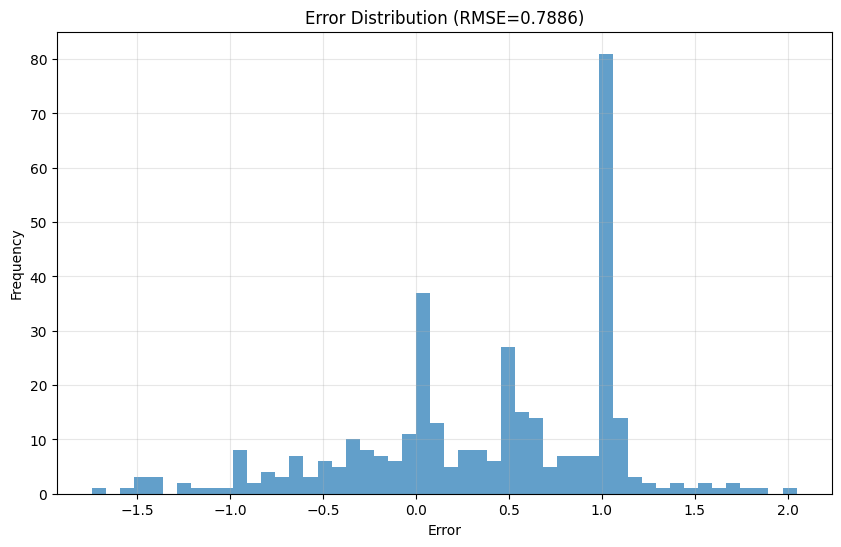

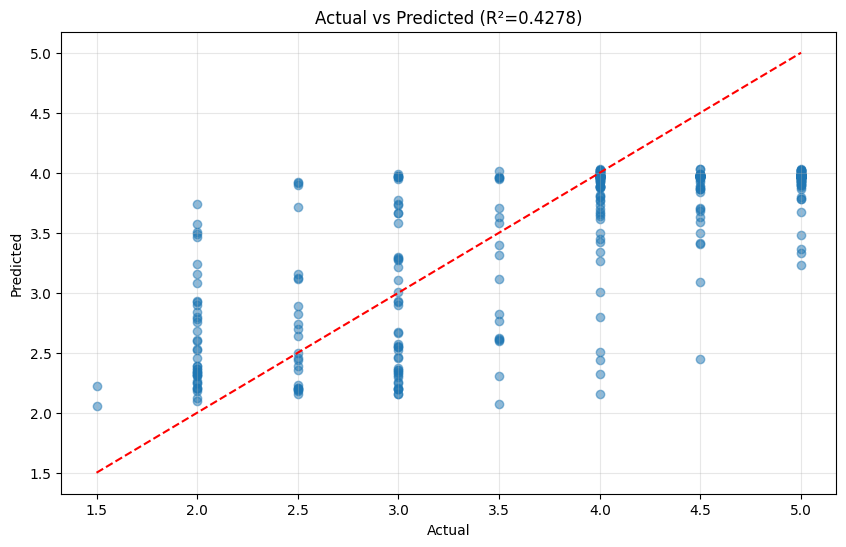


Evaluating CNN model on the entire dataset...


/tmp/ipykernel_31/1074165019.py:112: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cnn_model.load_state_dict(torch.load("CNN_best.pt", map_location=device))


Evaluating entire dataset:   0%|          | 0/12 [00:00<?, ?it/s]

Evaluation on entire dataset:
MSE: 0.3172
RMSE: 0.5632
MAE: 0.4696
R²: 0.7082
Pearson Correlation Coefficient (PCC): 0.9091

Error distribution statistics:
count    364.000000
mean       0.357710
std        0.435620
min       -1.608044
25%        0.115804
50%        0.350969
75%        0.709425
max        1.514732
Name: Error, dtype: float64


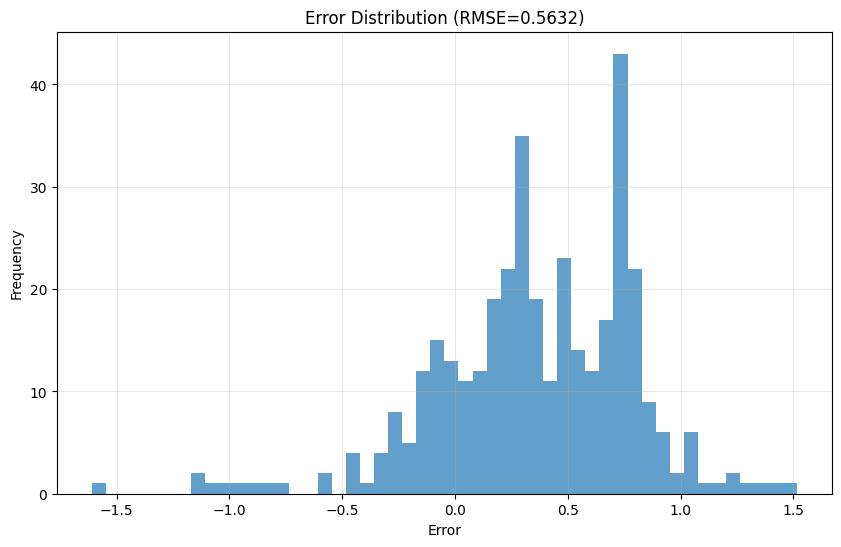

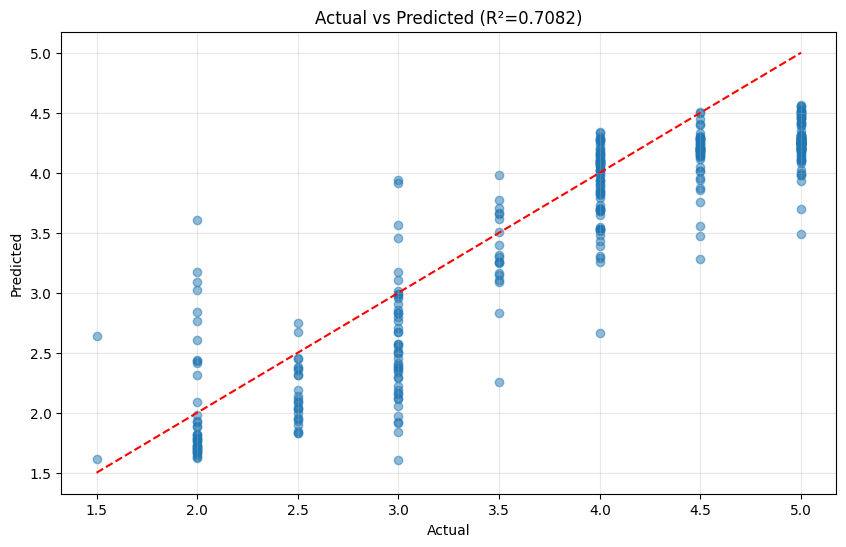


Model Comparison:
LSTM RMSE: 0.7886, PCC: 0.7573
CNN RMSE: 0.5632, PCC: 0.9091
RMSE Difference: 0.2254
PCC Difference: 0.1519


In [7]:
# Cell for calculating RMSE for the entire dataset
import torch
from torch.utils.data import DataLoader
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import math
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
from scipy.stats import pearsonr

# Assuming 'device', 'GrammarDataset', 'tokenizer', 'batch_size',
# 'BertLSTMGrammarScorer', and 'BertCNNGrammarScorer' are defined elsewhere
# and 'df' is your DataFrame containing 'transcription' and 'label' columns.

def calculate_rmse_for_entire_dataset(model, dataset_loader):
    """
    Calculate RMSE for the entire dataset using the provided model.

    Args:
        model: The trained model
        dataset_loader: DataLoader for the dataset

    Returns:
        A tuple containing (RMSE score, MSE score, MAE score, R² score, PCC score, predictions, actual labels, results DataFrame)
    """
    model.eval()
    all_predictions = []
    all_actual = []

    with torch.no_grad():
        for batch in tqdm(dataset_loader, desc="Evaluating entire dataset"):
            # Move data to device
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            # Get predictions
            outputs = model(input_ids, attention_mask)

            # Store predictions and actual values
            all_predictions.extend(outputs.view(-1).cpu().numpy())
            all_actual.extend(labels.cpu().numpy())

    # Calculate metrics
    mse = mean_squared_error(all_actual, all_predictions)
    rmse = math.sqrt(mse)
    mae = mean_absolute_error(all_actual, all_predictions)
    r2 = r2_score(all_actual, all_predictions)
    pcc, _ = pearsonr(all_actual, all_predictions)

    print(f"Evaluation on entire dataset:")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R²: {r2:.4f}")
    print(f"Pearson Correlation Coefficient (PCC): {pcc:.4f}")

    # Create a comprehensive DataFrame with all results
    results_df = pd.DataFrame({
        'Actual': all_actual,
        'Predicted': all_predictions,
        'Error': np.array(all_actual) - np.array(all_predictions),
        'Absolute Error': np.abs(np.array(all_actual) - np.array(all_predictions))
    })

    # Show error distribution
    print("\nError distribution statistics:")
    print(results_df['Error'].describe())

    # Plot error histogram if matplotlib is available
    try:
        import matplotlib.pyplot as plt
        plt.figure(figsize=(10, 6))
        plt.hist(results_df['Error'], bins=50, alpha=0.7)
        plt.title(f'Error Distribution (RMSE={rmse:.4f})')
        plt.xlabel('Error')
        plt.ylabel('Frequency')
        plt.grid(True, alpha=0.3)
        plt.show()

        # Scatter plot of actual vs predicted
        plt.figure(figsize=(10, 6))
        plt.scatter(all_actual, all_predictions, alpha=0.5)
        plt.plot([min(all_actual), max(all_actual)], [min(all_actual), max(all_actual)], 'r--')
        plt.title(f'Actual vs Predicted (R²={r2:.4f})')
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.grid(True, alpha=0.3)
        plt.show()
    except ImportError:
        print("Matplotlib not available for visualization.")

    return rmse, mse, mae, r2, pcc, all_predictions, all_actual, results_df

# Create a DataLoader for the entire dataset
full_dataset = GrammarDataset(df['transcription'].values, df['label'].values, tokenizer)
full_loader = DataLoader(
    full_dataset,
    batch_size=batch_size,
    pin_memory=True,
    num_workers=4
)

# Load the best models
print("\nEvaluating LSTM model on the entire dataset...")
lstm_model = BertLSTMGrammarScorer().to(device)
lstm_model.load_state_dict(torch.load("LSTM_best.pt", map_location=device))
lstm_rmse, lstm_mse, lstm_mae, lstm_r2, lstm_pcc, lstm_preds, lstm_actual, lstm_results_df = calculate_rmse_for_entire_dataset(lstm_model, full_loader)

print("\nEvaluating CNN model on the entire dataset...")
cnn_model = BertCNNGrammarScorer().to(device)
cnn_model.load_state_dict(torch.load("CNN_best.pt", map_location=device))
cnn_rmse, cnn_mse, cnn_mae, cnn_r2, cnn_pcc, cnn_preds, cnn_actual, cnn_results_df = calculate_rmse_for_entire_dataset(cnn_model, full_loader)

# Compare models
print("\nModel Comparison:")
print(f"LSTM RMSE: {lstm_rmse:.4f}, PCC: {lstm_pcc:.4f}")
print(f"CNN RMSE: {cnn_rmse:.4f}, PCC: {cnn_pcc:.4f}")
print(f"RMSE Difference: {abs(lstm_rmse - cnn_rmse):.4f}")
print(f"PCC Difference: {abs(lstm_pcc - cnn_pcc):.4f}")

# Save results to CSV for further analysis
lstm_results_df.to_csv('lstm_results.csv', index=False)
cnn_results_df.to_csv('cnn_results.csv', index=False)

# **Got a R2-score of 0.7082 using the CNN model on the entire train dataset.**

# **Transcribe test audio files**

In [5]:
import os
import pandas as pd
import whisper
import torch
from tqdm import tqdm

# Check if CUDA (GPU) is available
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# If CUDA is available, print GPU details
if device == "cuda":
    print(f"GPU: {torch.cuda.get_device_name()}")
    print(f"Total GPU Memory: {torch.cuda.get_device_properties(0).total_memory // (1024**2)} MB")
else:
    print("No GPU found, using CPU.")

# Load Whisper's large model and send it to the GPU (or CPU)
model = whisper.load_model("large").to(device)

# Load CSV file
csv_path = "/kaggle/input/shl-intern-hiring-assessment/Dataset/test.csv"
df = pd.read_csv(csv_path)

# Audio folder path
audio_dir = "/kaggle/input/shl-intern-hiring-assessment/Dataset/audios/test"

# Collect results
results = []

# Loop through each audio file
for idx, row in tqdm(df.iterrows(), total=len(df)):
    filename = row['filename']
    audio_path = os.path.join(audio_dir, filename)

    try:
        # Transcribe the audio using Whisper model
        result = model.transcribe(audio_path, fp16=(device == "cuda"))
        transcription = result['text'].strip()  # Clean up the transcription
    except Exception as e:
        print(f"Error transcribing {filename}: {e}")
        transcription = ""  # If error occurs, leave transcription empty

    # Append result to the list
    results.append({
        'filename': filename,
        'transcription': transcription
    })

# Save transcriptions and filename to a new CSV file
output_df = pd.DataFrame(results)
output_df.to_csv("whisper_transcribed_test.csv", index=False)

print("Transcription completed. The file 'whisper_transcribed_test.csv' has been saved.")


Using device: cuda
GPU: Tesla P100-PCIE-16GB
Total GPU Memory: 16269 MB


100%|██████████| 204/204 [1:10:08<00:00, 20.63s/it].88G [00:40<00:07, 87.1MiB/s]

Transcription completed. The file 'whisper_transcribed_test.csv' has been saved.


# **Running on the transribed test dataset.**

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel
from tqdm import tqdm

# Check for GPU availability and set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Define the CNN model architecture (identical to the original training script)
class BertCNNGrammarScorer(nn.Module):
    def __init__(self, bert_model='bert-base-uncased', dropout_rate=0.3):
        super(BertCNNGrammarScorer, self).__init__()
        self.bert = BertModel.from_pretrained(bert_model)
        
        # CNN layers with different kernel sizes for capturing different n-gram features
        self.conv1 = nn.Conv1d(in_channels=self.bert.config.hidden_size, out_channels=128, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=self.bert.config.hidden_size, out_channels=128, kernel_size=4, padding=1)
        self.conv3 = nn.Conv1d(in_channels=self.bert.config.hidden_size, out_channels=128, kernel_size=5, padding=2)
        
        self.dropout = nn.Dropout(dropout_rate)
        self.relu = nn.ReLU()
        
        # Regression head
        self.regressor = nn.Sequential(
            nn.Linear(128*3, 128),  # Concatenated output from 3 conv layers
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(128, 1)
        )
        
    def forward(self, input_ids, attention_mask):
        # Get BERT embeddings
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        sequence_output = outputs.last_hidden_state  # [batch_size, seq_len, hidden_size]
        
        # Transpose for CNN (expecting [batch, channels, seq_len])
        x = sequence_output.transpose(1, 2)  # [batch_size, hidden_size, seq_len]
        
        # Apply CNN layers
        c1 = self.relu(self.conv1(x))  # [batch_size, 128, seq_len]
        c2 = self.relu(self.conv2(x))  # [batch_size, 128, seq_len]
        c3 = self.relu(self.conv3(x))  # [batch_size, 128, seq_len]
        
        # Global max pooling
        c1 = torch.max(c1, dim=2)[0]  # [batch_size, 128]
        c2 = torch.max(c2, dim=2)[0]  # [batch_size, 128]
        c3 = torch.max(c3, dim=2)[0]  # [batch_size, 128]
        
        # Concatenate
        cnn_output = torch.cat((c1, c2, c3), dim=1)  # [batch_size, 384]
        
        # Apply dropout
        cnn_output = self.dropout(cnn_output)
        
        # Regression head
        score = self.regressor(cnn_output)
        
        return score

# Dataset for unlabeled data
class UnlabeledGrammarDataset(Dataset):
    def __init__(self, texts, filenames, tokenizer, max_length=512):
        self.texts = texts
        self.filenames = filenames
        self.tokenizer = tokenizer
        self.max_length = max_length
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        filename = self.filenames[idx]
        
        # Tokenize the text
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'filename': filename
        }


# Load the unlabeled dataset
# Replace with your actual file path
df_unlabeled = pd.read_csv('/kaggle/working/whisper_transcribed_test.csv')

# Make sure the dataset has a 'transcription' column and a filename column
# Adjust column names as necessary
if 'transcription' not in df_unlabeled.columns:
    print("Error: The dataset must contain a 'transcription' column")
    

if 'filename' not in df_unlabeled.columns:
    print("Error: The dataset must contain a 'filename' column")
    

print(f"Unlabeled dataset loaded: {df_unlabeled.shape}")
print(df_unlabeled.head())

# Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Create dataset and dataloader
unlabeled_dataset = UnlabeledGrammarDataset(
    df_unlabeled['transcription'].values,
    df_unlabeled['filename'].values,
    tokenizer
)

batch_size = 16
unlabeled_loader = DataLoader(
    unlabeled_dataset,
    batch_size=batch_size,
    shuffle=False,  # Important: keep order for matching predictions with filenames
    pin_memory=True,
    num_workers=4
)

# Load the saved CNN model
model_path = "CNN_best.pt"  # Adjust if your model is saved with a different name

# Initialize the model
model = BertCNNGrammarScorer().to(device)

try:
    # Load the saved model weights
    if torch.cuda.is_available():
        model.load_state_dict(torch.load(model_path))
    else:
        model.load_state_dict(torch.load(model_path, map_location='cpu'))
    print(f"Model loaded successfully from {model_path}")
except Exception as e:
    print(f"Error loading model: {e}")
    

# Generate predictions
predictions = []
filenames = []

model.eval()  # Set model to evaluation mode

with torch.no_grad():
    for batch in tqdm(unlabeled_loader, desc="Generating predictions"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        batch_filenames = batch['filename']
        
        # Forward pass
        outputs = model(input_ids, attention_mask)
        
        # Store predictions and filenames
        batch_preds = outputs.view(-1).cpu().numpy()
        predictions.extend(batch_preds)
        filenames.extend(batch_filenames)

# Create a dataframe with results
results_df = pd.DataFrame({
    'filename': filenames,
    'label': predictions
})

# Save to CSV
output_path = 'submissions.csv'
results_df.to_csv(output_path, index=False)
print(f"Predictions saved to {output_path}")

Using device: cpu
Unlabeled dataset loaded: (204, 2)
         filename                                      transcription
0   audio_804.wav  My hobbies are playing cricket because I am a ...
1  audio_1028.wav  My favorite place is in Andhra Pradesh. It is ...
2   audio_865.wav  yeah my best my best days in my life is recent...
3   audio_774.wav  Actually, the most I use it to enjoy is like p...
4  audio_1138.wav  I would like to become a good engineer among t...


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

/tmp/ipykernel_31/253028272.py:145: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location='cpu'))


Model loaded successfully from CNN_best.pt


Generating predictions: 100%|██████████| 13/13 [03:34<00:00, 16.47s/it]

Predictions saved to submissions.csv
